In [1]:
import numpy as np
import pandas as pd
import optuna
import random
import os
from joblib import dump, load
os.environ['USE_PYGEOS'] = '0'
os.environ['PROJ_LIB'] = '/opt/conda/share/proj'
import geopandas as gpd
from tqdm.notebook import tqdm
import lightgbm as lgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [2]:
df_raw_path = 'overlayed_year_soil.type_v20250403_clean.pq'
df_raw = pd.read_parquet(df_raw_path)
print(f'Number of points raw: {df_raw.shape[0]}')

Number of points raw: 337751


In [3]:
#df_raw.to_csv('global.csv',index=False)

In [51]:
df_raw.columns.tolist()

['site_key',
 'olc_id',
 'year',
 'source_db',
 'longitude_decimal_degrees',
 'latitude_decimal_degrees',
 'taxsubgrp',
 'CHELSA_bio1_1981-2010_V.2.1',
 'CHELSA_pet_penman_max_1981-2010_V.2.1',
 'CHELSA_bio13_1981-2010_V.2.1',
 'CHELSA_kg2_1981-2010_V.2.1',
 'CHELSA_npp_1981-2010_V.2.1',
 'CHELSA_gddlgd10_1981-2010_V.2.1',
 'snow.prob_esacci.apr_p90_500m_s_20000101_20121231_go_epsg.4326_v2.0',
 'thermal_glad_swa.ard2_p25_30m_s_20000101_20221231_go_epsg.4326_v1',
 'pft.trees.be_esa.cci.lc_pc_300m_s_19920101_19921231_go_epsg.4326_v20230616',
 'biomes_biome6k.grassland_pscaled_1km_a_19790101_20131231_go_epsg.4326_v20241210',
 'CHELSA_tcc_mean_1981-2010_V.2.1',
 'twi_edtm_m_120m_s_20000101_20221231_go_epsg.4326_v20241230',
 'snow.prob_esacci.oct_p90_500m_s_20000101_20121231_go_epsg.4326_v2.0',
 'CHELSA_gddlgd5_1981-2010_V.2.1',
 'dtm_landform_usgs.ecotapestry.low.hills_p_250m_s0..0cm_2014_v1.0',
 'CHELSA_gsp_1981-2010_V.2.1',
 'dtm_landform_usgs.ecotapestry.flat.plains_p_250m_s0..0cm_2014_

# Preprocess

In [5]:
df = df_raw.drop(columns=['site_key', 
                          'year', 
                          'source_db', 
                          'longitude_decimal_degrees', 
                          'latitude_decimal_degrees']).copy() # 
df.shape

(337751, 210)

In [6]:
# Removing bad features (>20% of missing values)
select_columns = (df.isna().sum() / len(df)) <= 0.1
df_all = df.loc[:,select_columns]
df_all = df_all.dropna()
df_all.shape

(321295, 210)

In [7]:
# Spatial blocking rule
df_all['blocking'] = df_all['olc_id'].str.split('+').apply(lambda x: x[0])

In [8]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Step 1: Fit LabelEncoder on Training Data
y_encoded = label_encoder.fit_transform(df_all['taxsubgrp'])

# Save the mapping
mapping_df = pd.DataFrame({
    'Label': label_encoder.classes_,
    'Code': range(len(label_encoder.classes_))
})

In [9]:
mapping_df

,Label,Code
0,abruptic durixeralfs,0
1,abruptic xeric argidurids,1
2,aeric alaquods,2
3,aeric albaqualfs,3
4,aeric calciaquolls,4
...,...,...
813,xeric palehumults,813
814,xeric torrifluvents,814
815,xeric torriorthents,815
816,xeric torripsamments,816


# Feature Selection

In [ ]:
from sklearn.ensemble import RandomForestClassifier

def feature_selection_DEPRECATED(samples, features, target_feature, subsampling, group_feature, weights_feature=None):
    # Data preparation
    groups = samples[group_feature].unique()
    # selected_groups = np.random.choice(groups, int(len(groups) * subsampling), False)
    selected_groups = np.array(
        samples.groupby(target_feature)[group_feature]
            .apply(lambda x: x.sample(frac=subsampling).tolist())
            .explode()
            .tolist()
    )
    # Split
    samples_train = samples[samples[group_feature].isin(selected_groups)]
    # Get features
    X_train = samples_train[features].to_numpy()
    y_train = samples_train[target_feature].to_numpy()
    # Feature Selection
    clf = RandomForestClassifier(n_jobs=-1, n_estimators = 50, bootstrap=True)
    # Get weights
    if weights_feature is not None:
        weights_oc = samples_train[weights_feature].to_numpy()
        clf.fit(X_train, y_train, weights_oc)
    else:
        clf.fit(X_train, y_train)
    importances = pd.Series(clf.feature_importances_, index=features).sort_values(ascending=True)
    # RF & mean decrease in impurity
    importances = importances[importances>=importances.mean()]
    # return feature names and importance
    return (importances.index, np.array(importances.to_list()))


def feature_selection(samples, features, target_feature, subsampling, group_feature, weights_feature=None):
    # Data preparation
    groups = samples[group_feature].unique()
    selected_groups = np.array(
        samples.groupby(target_feature)[group_feature]
            .apply(lambda x: x.sample(frac=subsampling).tolist())
            .explode()
            .tolist()
    )
    # Split
    samples_train = samples[samples[group_feature].isin(selected_groups)]
    print(samples_train.index)
    
    # Get features
    X_train = samples_train[features].to_numpy()
    y_train = samples_train[target_feature].to_numpy()
    
    # Feature Selection
    clf = RandomForestClassifier(n_jobs=-1, n_estimators=50, bootstrap=True)
    
    # Get weights
    if weights_feature is not None:
        weights_oc = samples_train[weights_feature].to_numpy()
        clf.fit(X_train, y_train, sample_weight=weights_oc)
    else:
        clf.fit(X_train, y_train)
    
    # Compute feature importances
    importances = pd.Series(clf.feature_importances_, index=features).sort_values(ascending=False)
    
    # Select the top features
    top_features = importances.head(100)
    
    # Return feature names and their importance values
    return top_features.index.tolist(), top_features.to_numpy()

In [ ]:
np.random.seed(42)
target_feature = 'taxsubgrp'
subsampling = 0.8
df_all.loc[:,'blocking_coarse'] = df_all['olc_id'].str[:5].copy()
group_feature = 'blocking_coarse'#'blocking'
weights_feature = None
rounds = 25

df_all['codes'] = df_all[target_feature].astype('category').cat.codes
target_feature = 'codes'
features = df_all.columns[2:-5].tolist()
#features = df_all.columns.drop(['olc_id', 'taxsubgrp', 'lon','lat','geometry','overlay_id','blocking','codes','geometry'])
runs = [feature_selection(df_all, features, target_feature, subsampling, group_feature, weights_feature) for i in tqdm(range(rounds))]

features_freq = feature_list.groupby('freq').count().reset_index().sort_values(by='freq', ascending=False)
features_freq['accum'] = features_freq['feature'].cumsum()
features_freq

In [10]:
features_repeated = pd.read_csv('feature_selection_v20250403_clean.csv')
features_repeated = features_repeated['feature'].tolist()

In [11]:
class_freq = df_all[target_feature].value_counts()
class_cat = class_freq[class_freq >= 25].index
class_mask = df_all[target_feature].isin(class_cat) 
df_all_masked = df_all[class_mask].copy()

In [12]:
random.seed(102)
df_all_masked.loc[:,'blocking_coarse'] = df_all_masked['olc_id'].str[:5].copy()
class20 = df_all_masked.groupby(target_feature).apply(lambda group: group.sample(int(len(group)*0.2))).reset_index(drop=True)
df_class20 = df_all_masked.groupby(target_feature).apply(lambda group: group.sample(int(len(group)*0.2)))


In [13]:
indices_to_exclude = df_class20.index.get_level_values(1)

df_remaining = df_all_masked.loc[~df_all_masked.index.isin(indices_to_exclude), :].copy()

# Testing samples
total_samples = int(0.05 * len(df_all_masked))

# Spatial blocking rule
df_remaining.loc[:,'blocking_coarse'] = df_remaining['olc_id'].str[:5].copy()
unique_blocks = df_remaining['blocking_coarse'].nunique()

# the number of samples per block
samples_per_block = 1 #max(1, total_samples // unique_blocks) 

# Sample the data from each block
df_test = df_remaining.groupby('blocking_coarse').apply(lambda x: x.sample(n=min(len(x), 2), random_state=102))

df_train = df_remaining.drop(df_test.index.get_level_values(1), axis=0)

df_test = df_test.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)

In [14]:
X_train = df_train[features_repeated].copy()
#y_train = df_train[target_feature].astype('category').cat.codes
y_train = df_train['codes']
lgb_traing = lgb.Dataset(X_train, label=y_train)

X_test = df_test[features_repeated].copy()
#y_test = df_test[target_feature].astype('category').cat.codes
y_test = df_test['codes']
lgb_test = lgb.Dataset(X_test, label=y_test)

print(f'Training sample size: {X_train.shape[0]} | Testing sample size: {X_test.shape[0]} ')

Training sample size: 220381 | Testing sample size: 36950 


In [15]:
categories = df_train[target_feature].astype('category').cat.categories
codes = df_train[target_feature].astype('category').cat.codes

mapping_df_train = pd.DataFrame({
    'Label': categories,
    'Code': range(len(categories))
})
categories = df_test[target_feature].astype('category').cat.categories
codes = df_test[target_feature].astype('category').cat.codes

mapping_df_test = pd.DataFrame({
    'Label': categories,
    'Code': range(len(categories))
})

#mapping_df.to_csv('label_code_mapping.txt', index=False, sep='\t')

# Train MODELS

# RandomForest

In [45]:
import pandas as pd
from functools import partial
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedGroupKFold, cross_val_score
from sklearn.metrics import log_loss, make_scorer
import optuna

n_splits = 5

class20.reset_index(drop=True, inplace=True)  

X_class20 = class20[features_repeated].copy()
y_class20 = class20[target_feature].copy()
groups_class20 = class20[group_feature]  

splitter = StratifiedGroupKFold(n_splits=n_splits)
folds = list(splitter.split(X_class20, y_class20, groups=groups_class20))

def objective(trial):
    params = {
        'n_estimators': 50,
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        'max_features': trial.suggest_float('max_features', 0.5, 1.0),
        'bootstrap': True
    }
    
    clf = RandomForestClassifier(**params, random_state=987, n_jobs=96)
    
    scorer = make_scorer(log_loss, greater_is_better=False, needs_proba=True)

    scores = cross_val_score(clf, X_class20, y_class20, cv=folds, scoring=scorer)
    
    return -np.round(scores.mean(),3)

study_name = "soil_type_RF_v20250402"
storage_name = f"sqlite:///{study_name}.db"
study = optuna.create_study(direction='minimize', study_name=study_name, storage=storage_name)
#study = optuna.load_study(study_name=study_name, storage=storage_name)

study.optimize(objective, n_trials=50)  
best_trial_rf = study.best_trial

print("Best Hyperparameters: ", best_trial_rf.params)
print("Best Log Loss: ", best_trial_rf.value)


# LightGBM

In [ ]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import StratifiedGroupKFold
import optuna

n_splits = 5

class20.reset_index(drop=True, inplace=True)  

X_class20 = class20[features_repeated]
y_class20 = class20[target_feature].copy() 
groups_class20 = class20[group_feature]  

splitter = StratifiedGroupKFold(n_splits=n_splits)
folds = list(splitter.split(X_class20, y_class20, groups=groups_class20))
folds_lightgbm = [(train_idx.tolist(), test_idx.tolist()) for train_idx, test_idx in folds]

def objective(trial):
    params = {
        'objective': 'multiclass',
        'metric': 'multi_logloss',
        'num_class': df_all[target_feature].nunique(),
        'boosting_type': 'gbdt',
        'num_leaves': 50,
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 20, 100),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.5, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.5, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'lambda_l1': trial.suggest_float('lambda_l1', 0.0, 10.0),
        'lambda_l2': trial.suggest_float('lambda_l2', 0.0, 10.0),
        'min_gain_to_split': trial.suggest_float('min_gain_to_split', 0.0, 1.0),
        'num_boost_round': 10,
        'num_threads': 96,
        'verbose': -1
    }

    lgb_data = lgb.Dataset(X_class20, label=y_class20)#, weight=weights_class20)
    
    cv_results_lgb20 = lgb.cv(
        params,
        lgb_data,
        num_boost_round=10,
        folds=folds_lightgbm,
        seed=987,
        return_cvbooster=False,
        callbacks=[lgb.early_stopping(stopping_rounds=10)] 
    )
    
    logloss_values = cv_results_lgb20['valid multi_logloss-mean']
    
    min_logloss = min(logloss_values)
    best_iteration_lgb20 = logloss_values.index(min_logloss)

    trial.set_user_attr("best_iteration", best_iteration_lgb20)
    
    return min_logloss

study_name = 'LGB_v20250402'
storage_name = f"sqlite:///{study_name}.db".format(study_name)
study = optuna.create_study(direction='minimize', study_name=study_name, storage=storage_name)
#study = optuna.load_study(study_name=study_name, storage=storage_name)

study.optimize(objective, n_trials=50) 
best_trial_lgb20 = study.best_trial

print("Best Hyperparameters: ", best_trial_lgb20.params)
print("Best Log Loss: ", best_trial_lgb20.value)  # Log loss value
print("Best Iteration Round: ", best_trial_lgb20.user_attrs["best_iteration"] + 1)  


# Testing set

In [ ]:
y_pred = final_model.predict(X_test, num_iteration=final_model.best_iteration)
y_pred_hcl_test = np.argmax(y_pred, axis=1)
#y_code_train = df_all[target_feature].astype('category').cat.codes

print(classification_report(y_test, y_pred_hcl_test, zero_division=0))

In [ ]:
X = df_all[features_repeated].copy()
y = df_all['codes']
#y = df_all[target_feature].astype('category').cat.codes

lgb_all = lgb.Dataset(X, label=y)

final_model = lgb.train(
    best_params,
    lgb_all,
)

Feature Importances (%):
                                              Feature  Importance (%)
58  legendtm_rf_30m_m_s_20000101_20231231_go_epsg....        3.150669
10                        CHELSA_bio4_1981-2010_V.2.1        2.996826
9                         CHELSA_bio3_1981-2010_V.2.1        2.927759
4                        CHELSA_bio15_1981-2010_V.2.1        2.876624
47                     CHELSA_tcc_min_1981-2010_V.2.1        2.751428
..                                                ...             ...
94  tan.curv_edtm_m_120m_s_20000101_20221231_go_ep...        0.073404
95  tan.curv_edtm_m_240m_s_20000101_20221231_go_ep...        0.071807
96  tan.curv_edtm_m_60m_s_20000101_20221231_go_eps...        0.067914
79  pos.openness_edtm_m_240m_s_20000101_20221231_g...        0.065333
56  dfme_edtm_m_60m_s_20000101_20221231_go_epsg.43...        0.057420

[100 rows x 2 columns]


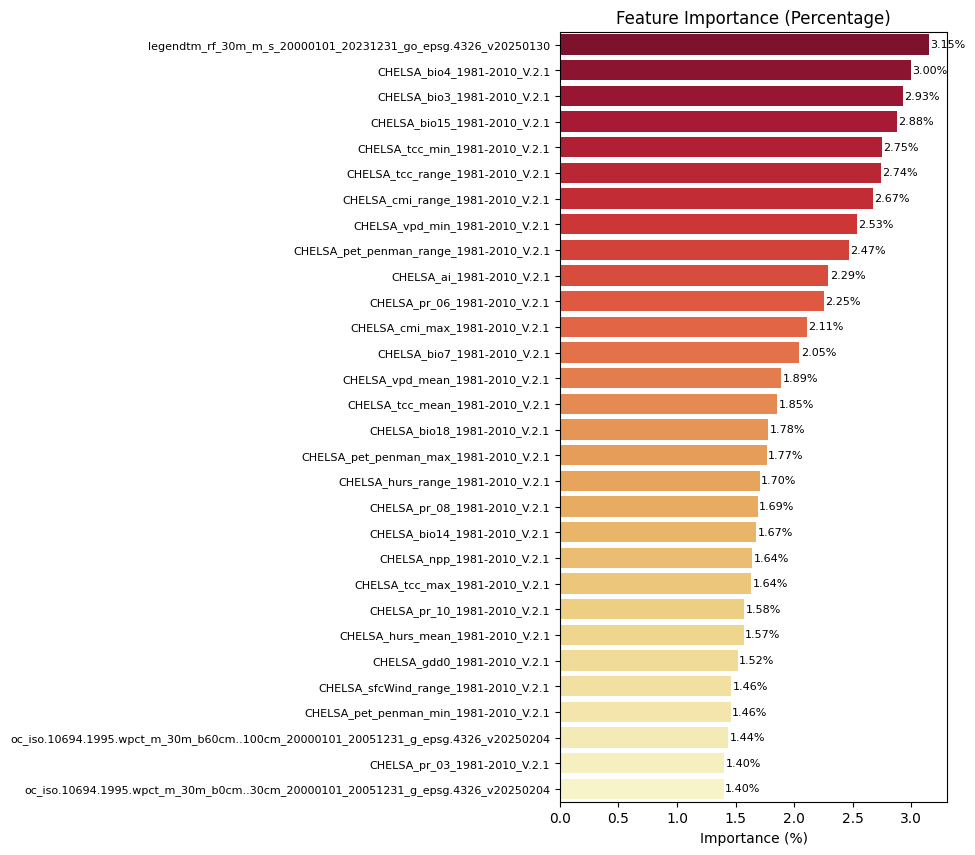

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances
feature_importances = final_model.feature_importance(importance_type='gain')

# Normalize to percentages
importance_percentages = 100 * feature_importances / feature_importances.sum()

# Create a Pandas Series for better visualization
lgb_importances = pd.Series(importance_percentages, index=features_repeated).sort_values(ascending=False)

# Create a DataFrame for better visualization
importance_df = pd.DataFrame({
    'Feature': final_model.feature_name(),
    'Importance (%)': importance_percentages
}).sort_values(by='Importance (%)', ascending=False)

# Display the feature importances as percentages
print("Feature Importances (%):")
print(importance_df)

# Plot feature importances as percentages
fig, ax = plt.subplots(figsize=(5, 10))
bar = sns.barplot(
    y=lgb_importances.index[:30],
    x=lgb_importances.values[:30],
    orient="h",
    palette='YlOrRd_r',
    ax=ax
)
ax.set_yticklabels(lgb_importances.index[:30], fontsize=8)
bar.bar_label(bar.containers[0], label_type='edge', rotation=0, color='black', padding=1, fmt='%.2f%%', fontsize=8)

plt.xlabel('Importance (%)')
plt.title('Feature Importance (Percentage)')
#fig.savefig('LGB_FeatureImportance_BestModel_Percentage.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
y_pred_train = final_model.predict(X_train, num_iteration=final_model.best_iteration)
y_pred_hcl_train = np.argmax(y_pred_train, axis=1)
y_code_train = df_train[target_feature].astype('category').cat.codes

print(classification_report(y_code_train, y_pred_hcl_train, zero_division=0))

In [ ]:
y_pred_test = final_model.predict(X_test, num_iteration=final_model.best_iteration)
y_pred_hcl_test = np.argmax(y_pred_test, axis=1)
y_code_test = df_test[target_feature].astype('category').cat.codes

print(classification_report(y_code_test, y_pred_hcl_test, zero_division=0))